In [2]:
import os
import numpy as np
import random
import copy
from collections import defaultdict

import matplotlib.pyplot as plt

plt.rc("font", size=8)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataloader import CleanSineDataset
from autoencoder_models import RNNEncoder, RNNDecoder, Seq2SeqAttn
from svdd_models import ReccurentSVDD
from data_utils import pad_collate

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

e = RNNEncoder(input_dim=1, bidirectional=True).to(device)
d = RNNDecoder(
    input_dim=(e.input_size + e.hidden_size * 2),
    hidden_size=e.hidden_size,
    bidirectional=True,
).to(device)

ae_model = Seq2SeqAttn(encoder=e, decoder=d).to(device)

model = ReccurentSVDD(base_encoder=ae_model.encoder)
model.load_state_dict(torch.load("svdd_sin_weights_145.pt"))

<All keys matched successfully>

In [7]:
center = torch.tensor([-0.1000, -0.3285,  0.1867, -0.1000, -0.1093,  0.1832, -0.1000,  0.1697,
         0.2774, -0.2732,  0.1000,  0.1367,  0.1562,  0.1000,  0.1551,  0.1000,
         0.1513, -0.1000,  0.1000, -0.1000,  0.3307, -0.1000, -0.1711,  0.1000,
        -0.1000, -0.1545,  0.1126,  0.1000,  0.1000,  0.1780, -0.1232, -0.2564,
        -0.1000,  0.1540,  0.2733,  0.1000, -0.1000, -0.1000,  0.2511,  0.2235,
        -0.1009, -0.1000,  0.1000,  0.1021, -0.2716, -0.2123,  0.1542, -0.1000,
        -0.4258,  0.1000, -0.1500, -0.1028,  0.1982, -0.1416, -0.2465, -0.1000,
         0.2258,  0.2194, -0.1066, -0.1466,  0.1000,  0.2482,  0.1920, -0.1227,
        -0.1000, -0.1000, -0.2575, -0.1063,  0.1104, -0.1391,  0.2258, -0.1000,
         0.1000, -0.1000, -0.1080,  0.1000, -0.2826, -0.1000,  0.1000, -0.2046,
         0.2424, -0.2982,  0.2066, -0.3908, -0.1193,  0.1461, -0.2740,  0.1000,
        -0.1000, -0.1000,  0.1000,  0.2446,  0.2489,  0.3152,  0.1000, -0.1000,
         0.1000,  0.1000,  0.1000, -0.2627, -0.1000, -0.3285,  0.1867, -0.1000,
        -0.1093,  0.1832, -0.1000,  0.1697,  0.2774, -0.2732,  0.1000,  0.1367,
         0.1562,  0.1000,  0.1551,  0.1000,  0.1513, -0.1000,  0.1000, -0.1000,
         0.3307, -0.1000, -0.1711,  0.1000, -0.1000, -0.1545,  0.1126,  0.1000,
         0.1000,  0.1780, -0.1232, -0.2564, -0.1000,  0.1540,  0.2733,  0.1000,
        -0.1000, -0.1000,  0.2511,  0.2235, -0.1009, -0.1000,  0.1000,  0.1021,
        -0.2716, -0.2123,  0.1542, -0.1000, -0.4258,  0.1000, -0.1500, -0.1028,
         0.1982, -0.1416, -0.2465, -0.1000,  0.2258,  0.2194, -0.1066, -0.1466,
         0.1000,  0.2482,  0.1920, -0.1227, -0.1000, -0.1000, -0.2575, -0.1063,
         0.1104, -0.1391,  0.2258, -0.1000,  0.1000, -0.1000, -0.1080,  0.1000,
        -0.2826, -0.1000,  0.1000, -0.2046,  0.2424, -0.2982,  0.2066, -0.3908,
        -0.1193,  0.1461, -0.2740,  0.1000, -0.1000, -0.1000,  0.1000,  0.2446,
         0.2489,  0.3152,  0.1000, -0.1000,  0.1000,  0.1000,  0.1000, -0.2627],
       device='cuda:0')

In [8]:
clean_dataset = CleanSineDataset()


clean_dataloader = DataLoader(
    clean_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    collate_fn=pad_collate,
)

In [29]:
(_, anchor_batch, anchor_lens) = next(iter(clean_dataloader))
anchor_batch = anchor_batch.to(device)

print(anchor_batch.shape)
print(anchor_lens)
expert_hidden = model.encoded_embedding(anchor_batch, anchor_lens)

dist = ((expert_hidden - center) ** 2).view(-1)
dist = torch.sum(dist)
if np.abs(dist.item()) <= 0.001:
    print("in circle", dist)
else:
    print("out circle", dist)

torch.Size([10, 50, 1])
tensor([50., 50., 50., 50., 50., 50., 50., 50., 50., 50.])
in circle tensor(1.0565e-06, device='cuda:0', grad_fn=<SumBackward0>)


In [46]:
x = np.linspace(1*np.pi, 8*np.pi, 50)
tan = np.tan(x)

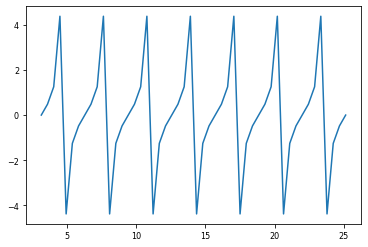

In [47]:
plt.plot(x, tan)

In [48]:
anchor_batch = torch.from_numpy(tan).to(device).view(1, -1, 1).float()
anchor_lens = torch.tensor([50], dtype= torch.long)

expert_hidden = model.encoded_embedding(anchor_batch, anchor_lens)

dist = ((expert_hidden - center) ** 2).view(-1)
dist = torch.sum(dist)
if np.abs(dist.item()) <= 0.001:
    print("in circle", dist)
else:
    print("out circle", dist)

out circle tensor(0.0096, device='cuda:0', grad_fn=<SumBackward0>)
